In [2]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import soundfile as sf
import webdataset as wds
import multiprocessing as mp
import glob
from utils import *
import os
from collections import Counter

In [3]:
total = pd.read_csv(config['TOTAL']['PATH_TO_LABEL'])

In [26]:
train = total[total['Split_Set'] == 'Train']
valid = total[total['Split_Set'] == 'Development']

In [27]:
len(train),len(valid)

(66769, 16504)

In [28]:
Counter(train['dominant_emotion'])

Counter({'neutral': 32131,
         'happy': 18645,
         'sad': 6016,
         'angry': 5003,
         'surprise': 2687,
         'contempt': 2287})

In [12]:
len(total)

83273

In [13]:
# Display the first few rows of the dataset
# total.head()

# Create a function to sample 10% of the data while preserving class distribution
def sample_stratified(df, frac=0.1, random_state=42):
    # Group by split set and emotion
    groups = df.groupby(['Split_Set', 'dominant_emotion'])
    sampled_dfs = []
    
    # Sample each group separately
    for name, group in groups:
        sampled_group = group.sample(frac=frac, random_state=random_state)
        sampled_dfs.append(sampled_group)
    
    # Combine all sampled groups
    return pd.concat(sampled_dfs)

# Create a 10% sample of the dataset
total_sampled = sample_stratified(total, frac=0.1)

# Verify the size reduction
print(f"Original dataset size: {len(total)}")
print(f"Sampled dataset size: {len(total_sampled)} ({len(total_sampled)/len(total):.2%})")

# Verify emotion distribution is preserved
print("\nEmotion distribution in original dataset:")
print(total.groupby(['Split_Set', 'dominant_emotion']).size())
print("\nEmotion distribution in sampled dataset:")
print(total_sampled.groupby(['Split_Set', 'dominant_emotion']).size())

# Replace the original dataframe with the sampled one
total = total_sampled

Original dataset size: 83273
Sampled dataset size: 8328 (10.00%)

Emotion distribution in original dataset:
Split_Set    dominant_emotion
Development  angry                2676
             contempt             1352
             happy                4067
             neutral              6262
             sad                  1386
             surprise              761
Train        angry                5003
             contempt             2287
             happy               18645
             neutral             32131
             sad                  6016
             surprise             2687
dtype: int64

Emotion distribution in sampled dataset:
Split_Set    dominant_emotion
Development  angry                268
             contempt             135
             happy                407
             neutral              626
             sad                  139
             surprise              76
Train        angry                500
             contempt             229
     

In [8]:
total.to_csv('/datas/store163/othsueh/Emo_analyze/newset/train&val_eps0.045_small.csv')

In [2]:
from transformers import AutoProcessor, AutoModel
model_name = "wav2vec2-large-960h"
model_path = config["PATH_TO_PRETRAINED_MODELS"] 
model_path = os.path.join(model_path, model_name)
assert os.path.exists(model_path), f"Model path {model_path} does not exist."
feature_extractor = AutoProcessor.from_pretrained(model_path, use_fast=False)
model = AutoModel.from_pretrained(model_path)
# Check if CUDA is available and assert GPU usage
assert torch.cuda.is_available(), "CUDA is not available. Please use a GPU to run this code."
model = model.to('cuda')

/datas/store163/othsueh/miniconda3/envs/msp_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at ./FeatureExtraction/models/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

In [6]:
# for name, module in model.named_modules():
#     print(name)
def freeze_all_except(model, unfreeze_keys):
    for name, param in model.named_parameters():
        param.requires_grad = any(key in name for key in unfreeze_keys)
fire_layers = ['encoder.layers.22','encoder.layers.23']
freeze_all_except(model,fire_layers)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params) #origin : 315428992

25192448


In [27]:
import soundfile as sf

In [42]:
samples, sr = sf.read(os.path.join(config['MSPPODCAST']['PATH_TO_AUDIO'],'MSP-PODCAST_3037_0712.wav'))
input_values = feature_extractor(samples, sampling_rate=sr, return_tensors="pt").input_values
input_values = input_values.to('cuda')
with torch.no_grad():
    last_hidden_state = model(input_values).last_hidden_state

last_hidden_state.shape

torch.Size([1, 172, 1024])

In [3]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

315428992


In [ ]:
model = net.MOE(1280,1024,dropout=0.2,fusion_type='bilinear',num_experts=3).cuda()
numel_list = [p.numel() for p in model.parameters()]
total_params = sum(numel_list)
print(total_params)

In [ ]:
numel_list

In [58]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
print(input)
print(target)

tensor([[ 1.0593, -0.5259, -0.4126, -1.2237, -1.0999],
        [ 0.2725,  0.1745,  1.4604, -0.2560,  0.4010],
        [ 0.3831,  0.0097,  1.1761, -0.1994,  2.6107]], requires_grad=True)
tensor([[0.2939, 0.3446, 0.2175, 0.0216, 0.1223],
        [0.0919, 0.1213, 0.1271, 0.4115, 0.2481],
        [0.3606, 0.0967, 0.1421, 0.3822, 0.0183]])


In [57]:
cm1 = torch.tensor([[1,0,3],[4,0,6],[7,0,9]])
cm2 = np.array([[1,0,3],[4,0,6],[7,0,9]])
cs1 = cm1.sum(dim=1)
cs1 = cs1.masked_fill_(cs1 == 0, 1e-10)
cs2 = cm2.sum(axis=1, keepdims=True)
cs2 = np.where(cs2 == 0, 1e-10, cs2)
print(cm1/cs1)
print(cm2/cs2)
print(cs1, cs2)

tensor([[0.2500, 0.0000, 0.1875],
        [1.0000, 0.0000, 0.3750],
        [1.7500, 0.0000, 0.5625]])
[[0.25   0.     0.75  ]
 [0.4    0.     0.6   ]
 [0.4375 0.     0.5625]]
tensor([ 4, 10, 16]) [[ 4.]
 [10.]
 [16.]]


In [3]:
seed = 42
corpus = "MSPPODCAST"
text_feature_extractor = 'roberta-large-UTT'
audio_feature_extractor = 'whisper-large-v3-UTT'
seed = 42
batch = 16
# Data Preprocessing
corpus_path = config[corpus]["PATH_TO_LABEL"]
corpus_df = pd.read_csv(corpus_path)
corpus_df["FileName"]= corpus_df["FileName"].str.replace('.wav', '')
# Remove non consensus labels
main_corpus_df = corpus_df[~corpus_df["EmoClass"].isin(["X", "O"])]
# Create train/val splits
train_df = main_corpus_df[corpus_df["Split_Set"] == "Train"]
val_df = main_corpus_df[corpus_df["Split_Set"] == "Development"]
# test_df = pd.read_csv(config[corpus]["PATH_TO_TEST"]) For evaluate.py
text_feature = get_feature_dir(corpus,text_feature_extractor)
audio_feature = get_feature_dir(corpus,audio_feature_extractor)

# Create datasets
train_dataset = MSPDataset(train_df, text_feature, audio_feature, seed=seed)
valid_dataset = MSPDataset(val_df, text_feature, audio_feature, seed=seed)
print(f"Number of training samples: {train_dataset.total_samples}")
print(f"Number of validation samples: {valid_dataset.total_samples}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch, num_workers=16)
valid_loader = DataLoader(valid_dataset, batch_size=batch, num_workers=16)

Number of training samples: 66992
Number of validation samples: 25258


/tmp/ipykernel_559821/3589435466.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df = main_corpus_df[corpus_df["Split_Set"] == "Train"]
/tmp/ipykernel_559821/3589435466.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_df = main_corpus_df[corpus_df["Split_Set"] == "Development"]


In [4]:
def indexEmotion(index_list):
    category_list = []
    emotions = ["Angry", "Sad", "Happy", "Surprise", "Fear", "Disgust", "Contempt", "Neutral"]
    for index in index_list:
        category_list.append(emotions[index])
    return category_list

Error loading file MSP-PODCAST_5575_0603: Text feature file not found: /datas/store162/othsueh/MSP-Podcast/Features/roberta-large-UTT/MSP-PODCAST_5575_0603.npy
Error loading file MSP-PODCAST_0794_0299: Text feature file not found: /datas/store162/othsueh/MSP-Podcast/Features/roberta-large-UTT/MSP-PODCAST_0794_0299.npy
Error loading file MSP-PODCAST_5568_0686: Text feature file not found: /datas/store162/othsueh/MSP-Podcast/Features/roberta-large-UTT/MSP-PODCAST_5568_0686.npy
Error loading file MSP-PODCAST_5685_0298: Text feature file not found: /datas/store162/othsueh/MSP-Podcast/Features/roberta-large-UTT/MSP-PODCAST_5685_0298.npy
Error loading file MSP-PODCAST_5724_1209: Text feature file not found: /datas/store162/othsueh/MSP-Podcast/Features/roberta-large-UTT/MSP-PODCAST_5724_1209.npy
Error loading file MSP-PODCAST_5730_1301: Text feature file not found: /datas/store162/othsueh/MSP-Podcast/Features/roberta-large-UTT/MSP-PODCAST_5730_1301.npy
Error loading file MSP-PODCAST_5526_0396

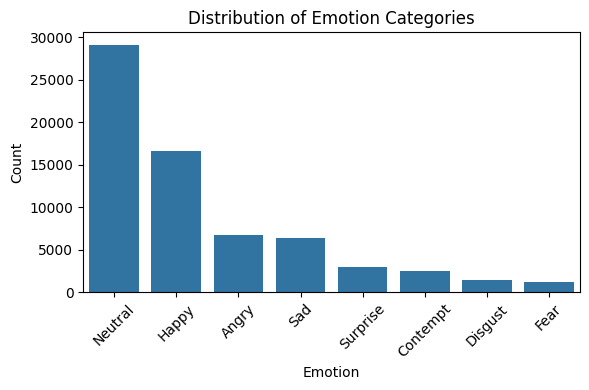

In [5]:
# Check distribution of emotion categories
total_categories = []
for batch_idx, (data, label) in enumerate(train_loader):
    category = label["category"]
    total_categories.extend(torch.argmax(category, dim=1).tolist())
category_list = indexEmotion(total_categories)

# Create distribution plot
plt.figure(figsize=(6, 4))
category_counts = pd.Series(category_list).value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Distribution of Emotion Categories')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
category_counts

Neutral     29144
Happy       16652
Angry        6716
Sad          6400
Surprise     2992
Contempt     2519
Disgust      1419
Fear         1134
Name: count, dtype: int64

In [41]:
# Calculate class weights inversely proportional to class frequencies
total_samples = len(category_list)
class_weights = []
emotions = ["Angry", "Sad", "Happy", "Surprise", "Fear", "Disgust", "Contempt", "Neutral"]
for emotion in emotions:
    count = category_counts.get(emotion, 0)
    if count == 0:
        weight = 1.0  # Handle case where class has no samples
    else:
        weight = total_samples / (len(emotions) * count)
    class_weights.append(weight)

# Convert to tensor for CrossEntropyLoss
class_weights = torch.FloatTensor(class_weights).cuda()
print("\nClass weights for CrossEntropyLoss:")
for emotion, weight in zip(emotions, class_weights):
    print(f"{emotion}: {weight:.3f}")


Class weights for CrossEntropyLoss:
Angry: 1.247
Sad: 1.308
Happy: 0.503
Surprise: 2.798
Fear: 7.383
Disgust: 5.900
Contempt: 3.324
Neutral: 0.287


In [8]:
m = nn.AdaptiveAvgPool1d(5)
input = torch.randint(1, 64, (8,))
input = input.float()

In [18]:
input

tensor([21., 58., 39., 51., 33., 56., 13., 28.])

In [21]:
test = []
for i in range(0,4):
    test.append(input[i:i+4].mean())
test


[tensor(42.2500), tensor(45.2500), tensor(44.7500), tensor(38.2500)]

In [19]:
output = m(input.unsqueeze(0))
output

tensor([[39.5000, 49.3333, 42.0000, 34.0000, 20.5000]])

In [20]:
m2 = nn.AvgPool1d(4, stride=1)
output2 = m2(input.unsqueeze(0))
output2

tensor([[42.2500, 45.2500, 44.7500, 38.2500, 32.5000]])

In [24]:
x = torch.rand(32,512)
x = x.unsqueeze(1)
x.shape

torch.Size([32, 1, 512])

In [16]:
8//3

2